In [312]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model 
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import QuantileRegressor

In [348]:
df = pd.read_csv('../data/data_synth.csv')
df = df.drop(columns=['times'])
data = df.to_numpy()

In [350]:
data_true = data

### error comp util 

In [371]:
def error(data_true, data_forecast):
    h = len(data_forecast[0])
    error = np.mean(np.array([mse(data_true[i+1:i+h+1],data_forecast[i]) for i in range(len(data_true)-h-1)]))

    return error

### hist mean forecasters

In [358]:
def previous_value_forecast(data_true,h=3):
    n = len(data_true)
    data_forecast = np.zeros((n, h, 2))
    
    for i in range(n):
        data_forecast[i,:,0] = data_true[i][0] 
        data_forecast[i,:,1] = data_true[i][1] 

    return data_forecast

def avg_value_forecast(data_true,h=3,w=7):
    n = len(data_true)
    data_forecast = np.zeros((n, h, 2))

    for i in range(n):
        supply_avg = np.mean(data_true[max(0,i-w+1):i+1,0])
        demand_avg = np.mean(data_true[max(0,i-w+1):i+1,1])

        data_forecast[i,:,0] = supply_avg
        data_forecast[i,:,1] = demand_avg
    return data_forecast
            

In [359]:
data_forecast_avg = avg_value_forecast(data_true,h=3,w=3)
data_forecast_last = previous_value_forecast(data_true,h=3)

print(error(data_true,data_forecast_avg))
print(error(data_true,data_forecast_last))

0.06362758267116775
0.03085794513751706


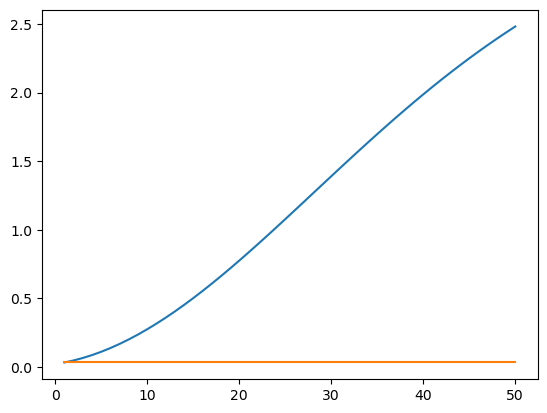

In [360]:
num = 50
avg_arr = np.linspace(1,50,50,dtype=int)
data_forecast_avg_arr = []
for avg in avg_arr:
    data_forecast_avg_arr.append(error(data_true,avg_value_forecast(data_true,h=3,w=avg)))

plt.plot(avg_arr,data_forecast_avg_arr)
plt.plot(avg_arr,error(data_true,previous_value_forecast(data_true,h=3))*np.ones(num))

In [361]:
np.argmin(data_forecast_avg_arr) +1

1

### lin reg forecaster

In [362]:
def linreg_joint_forecast(data_true, h = 3, w = 7): 
    n = len(data_true)
    forecast = np.zeros((n, h, 2))
    time_horizon = np.array([[x] for x in np.arange(1,h+1)])
    lin_model = linear_model.LinearRegression()
    
    for i in range(n):

        if (i < w ):
            time_hist_window  = np.array([[x] for x in np.arange(-i,1)])
        else: 
            time_hist_window = np.array([[x] for x in np.arange(-w+1,1)])

        history = data_true[max(0, i - w + 1):i + 1]

        lin_model.fit(time_hist_window, history)
        forecast[i] = lin_model.predict(time_horizon)
    return forecast   

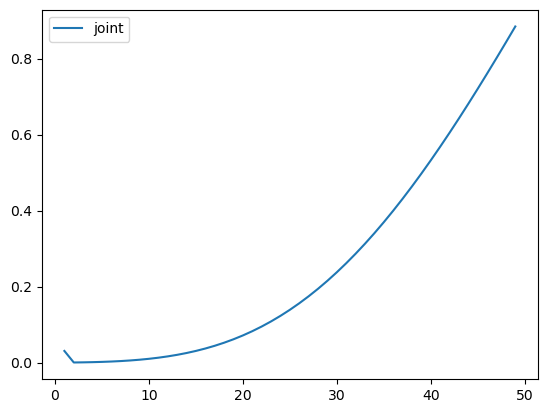

In [363]:
num = 50
w_arr = np.arange(1,num)
data_forecast__arr = []
data_forecast_linreg_arr = []
data_forecast_linreg_joint_arr = []
for w in w_arr:
    data_forecast_linreg_joint_arr.append(error(data_true,linreg_joint_forecast(data_true,h=3,w=w)))
    
plt.plot(w_arr,data_forecast_linreg_joint_arr, label = 'joint')
plt.legend()

In [364]:
np.argmin(data_forecast_linreg_joint_arr)+1

2

### quantile regression

In [210]:
def quantile_forecaster(data, h = 3, w = 7, gamma = 0.05, num = 5):

    n = len(data)
    quantiles = np.linspace(gamma, 1-gamma, num = num)
    quantiles = [0.5]
    time_horizon = np.array([[x] for x in np.arange(1,h+1)])
    forecast = np.zeros((n,len(quantiles), h, 2))

    for i in range(n):
        if (i < w ):
            time_hist_window  = np.array([[x] for x in np.arange(-i,1)])
        else: 
            time_hist_window = np.array([[x] for x in np.arange(-w+1,1)])

        history = data[max(0, i - w + 1):i + 1]
        blood_sup = history[:, 0]
        blood_dem = history[:, 1]
        
        
        for k, quantile in enumerate(quantiles): 
            qr_sup = QuantileRegressor(quantile=quantile, alpha=0)
            qr_dem = QuantileRegressor(quantile=quantile, alpha=0)
    
            qr_sup.fit(time_hist_window, blood_sup)
            qr_dem.fit(time_hist_window, blood_dem)

            sup_quantile_forecast = qr_sup.predict(time_horizon).T
            dem_quantile_forecast = qr_dem.predict(time_horizon).T
            
            forecast[i, k] = np.array([sup_quantile_forecast, dem_quantile_forecast]).T
            
    return forecast


In [211]:
data_hosp_A = data[:,0,:].T[:30]

In [212]:
qr_forecast = quantile_forecaster(data_hosp_A)

In [213]:
qr_forecast.shape

(30, 1, 3, 2)

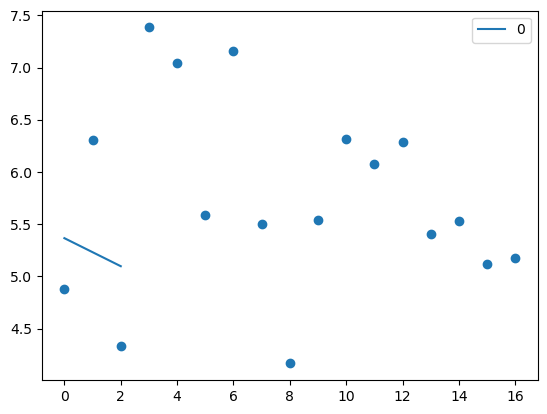

In [218]:
start = 20
end = start + 10
x = range(len(data_hosp_A[start-7:end, 0]))
plt.scatter(x,data_hosp_A[start-7:end,0])
for i in range(len(qr_forecast[start, :, :, 0])):
    plt.plot(qr_forecast[start, i, :, 0].T, label =f'{i}' )
    plt.legend()

In [215]:
len(qr_forecast[start, :, :, 0])

1

In [160]:
data[0].shape

(4, 2801)

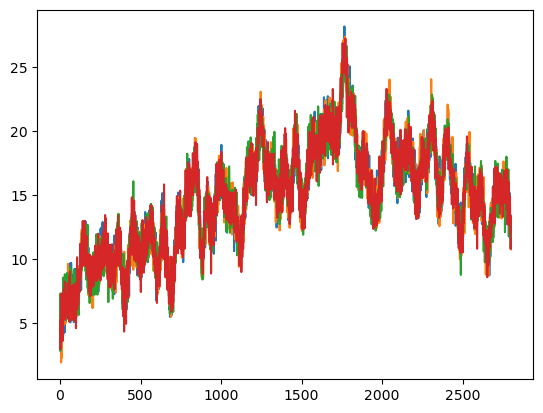

In [216]:
plt.plot(data[0].T)

### basic experiment

In [375]:
print('hosp A')
print('hold last:',np.round(error(data_true,previous_value_forecast(data_true,h=7)), decimals = 4))
print('hist mean: ',np.round(error(data_true,avg_value_forecast(data_true,h=7,w=7)), decimals = 4))
print('AR joint: ', np.round(error(data_true,linreg_joint_forecast(data_true,h=7,w=7)), decimals = 4))
print()

hosp A
hold last: 0.1306
hist mean:  0.3375
AR joint:  0.0247



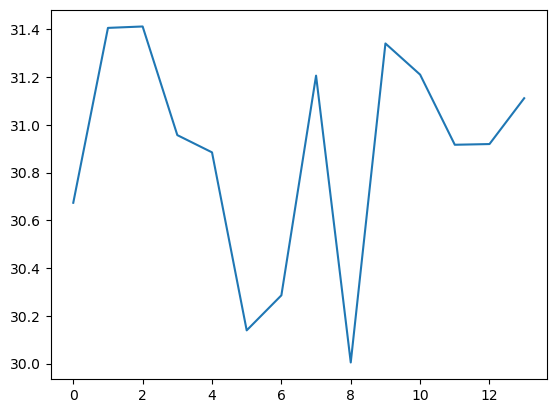

In [346]:
start = 30
end = start + 14
plt.plot(data[0,0,:][start:end])